#Anchors: High-Precision Model-Agnostic Explanations



In [54]:
!python --version

Python 3.7.10


In [55]:
pip install anchor-exp

In [56]:
from __future__ import print_function
from anchor_ import utils

import sklearn
import sklearn.ensemble
import numpy as np

import xgboost
import lime
import lime.lime_tabular

import collections
import copy
import string
import json
import sys
import io
from io import open
import argparse
import os
import pickle

In [57]:
np.random.seed(1)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#AnchorExplanation

In [58]:

class AnchorExplanation:
    """Object returned by explainers"""
    def __init__(self, type_, exp_map, as_html):
        self.type = type_
        self.exp_map = exp_map
        self.as_html_fn = as_html

    def names(self, partial_index=None):
        """
        Returns a list of the names of the anchor conditions.
        Args:
            partial_index (int): lets you get the anchor until a certain index.
            For example, if the anchor is (A=1,B=2,C=2) and partial_index=1,
            this will return ["A=1", "B=2"]
        """
        names = self.exp_map['names']
        if partial_index is not None:
            names = names[:partial_index + 1]
        return names

    def features(self, partial_index=None):
        """
        Returns a list of the features used in the anchor conditions.
        Args:
            partial_index (int): lets you get the anchor until a certain index.
            For example, if the anchor uses features (1, 2, 3) and
            partial_index=1, this will return [1, 2]
        """
        features = self.exp_map['feature']
        if partial_index is not None:
            features = features[:partial_index + 1]
        return features

    def precision(self, partial_index=None):
        """
        Returns the anchor precision (a float)
        Args:
            partial_index (int): lets you get the anchor precision until a
            certain index. For example, if the anchor has precisions
            [0.1, 0.5, 0.95] and partial_index=1, this will return 0.5
        """
        precision = self.exp_map['precision']
        if len(precision) == 0:
            return self.exp_map['all_precision']
        if partial_index is not None:
            return precision[partial_index]
        else:
            return precision[-1]

    def coverage(self, partial_index=None):
        """
        Returns the anchor coverage (a float)
        Args:
            partial_index (int): lets you get the anchor coverage until a
            certain index. For example, if the anchor has coverages
            [0.1, 0.5, 0.95] and partial_index=1, this will return 0.5
        """
        coverage = self.exp_map['coverage']
        if len(coverage) == 0:
            return 1
        if partial_index is not None:
            return coverage[partial_index]
        else:
            return coverage[-1]

    def examples(self, only_different_prediction=False,
                 only_same_prediction=False, partial_index=None):
        """
        Returns examples covered by the anchor.
        Args:
            only_different_prediction(bool): if true, will only return examples
            where the anchor  makes a different prediction than the original
            model
            only_same_prediction(bool): if true, will only return examples
            where the anchor makes the same prediction than the original
            model
            partial_index (int): lets you get the examples from the partial
            anchor until a certain index.
        """
        if only_different_prediction and only_same_prediction:
            print('Error: you can\'t have only_different_prediction \
and only_same_prediction at the same time')
            return []
        key = 'covered'
        if only_different_prediction:
            key = 'covered_false'
        if only_same_prediction:
            key = 'covered_true'
        size = len(self.exp_map['examples'])
        idx = partial_index if partial_index is not None else size - 1
        if idx < 0 or idx > size:
            return []
        return self.exp_map['examples'][idx][key]

    def as_html(self, **kwargs):
        return self.as_html_fn(self.exp_map, **kwargs)

    def show_in_notebook(self, **kwargs):
        from IPython.core.display import display, HTML
        out = self.as_html(**kwargs)
        display(HTML(out))

    def save_to_file(self, file_path, **kwargs):
        out = self.as_html(**kwargs)
        io.open(file_path, 'w').write(out)


##AnchorBaseBeam


In [59]:
"""Base anchor functions"""
from __future__ import print_function
import numpy as np
import operator
import copy
import sklearn
import collections


def matrix_subset(matrix, n_samples):
    if matrix.shape[0] == 0:
        return matrix
    n_samples = min(matrix.shape[0], n_samples)
    return matrix[np.random.choice(matrix.shape[0], n_samples, replace=False)]


class AnchorBaseBeam(object):
    def __init__(self):
        pass

    @staticmethod
    def kl_bernoulli(p, q):
        p = min(0.9999999999999999, max(0.0000001, p))
        q = min(0.9999999999999999, max(0.0000001, q))
        return (p * np.log(float(p) / q) + (1 - p) *
                np.log(float(1 - p) / (1 - q)))

    @staticmethod
    def dup_bernoulli(p, level):
        lm = p
        um = min(min(1, p + np.sqrt(level / 2.)), 1)
        qm = (um + lm) / 2.
#         print 'lm', lm, 'qm', qm, kl_bernoulli(p, qm)
        if AnchorBaseBeam.kl_bernoulli(p, qm) > level:
            um = qm
        else:
            lm = qm
        return um

    @staticmethod
    def dlow_bernoulli(p, level):
        um = p
        lm = max(min(1, p - np.sqrt(level / 2.)), 0)
        qm = (um + lm) / 2.
#         print 'lm', lm, 'qm', qm, kl_bernoulli(p, qm)
        if AnchorBaseBeam.kl_bernoulli(p, qm) > level:
            lm = qm
        else:
            um = qm
        return lm

    @staticmethod
    def compute_beta(n_features, t, delta):
        alpha = 1.1
        k = 405.5
        temp = np.log(k * n_features * (t ** alpha) / delta)
        return temp + np.log(temp)

    @staticmethod
    def lucb(sample_fns, initial_stats, epsilon, delta, batch_size, top_n,
             verbose=False, verbose_every=1):
        # initial_stats must have n_samples, positive
        n_features = len(sample_fns)
        n_samples = np.array(initial_stats['n_samples'])
        positives = np.array(initial_stats['positives'])
        ub = np.zeros(n_samples.shape)
        lb = np.zeros(n_samples.shape)
        for f in np.where(n_samples == 0)[0]:
            n_samples[f] += 1
            positives[f] += sample_fns[f](1)
        if n_features == top_n:
            return range(n_features)
        means = positives / n_samples
        t = 1

        def update_bounds(t):
            sorted_means = np.argsort(means)
            beta = AnchorBaseBeam.compute_beta(n_features, t, delta)
            J = sorted_means[-top_n:]
            not_J = sorted_means[:-top_n]
            for f in not_J:
                ub[f] = AnchorBaseBeam.dup_bernoulli(means[f], beta /
                                                     n_samples[f])
            for f in J:
                lb[f] = AnchorBaseBeam.dlow_bernoulli(means[f],
                                                      beta / n_samples[f])
            ut = not_J[np.argmax(ub[not_J])]
            lt = J[np.argmin(lb[J])]
            return ut, lt
        ut, lt = update_bounds(t)
        B = ub[ut] - lb[lt]
        verbose_count = 0
        while B > epsilon:
            verbose_count += 1
            if verbose and verbose_count % verbose_every == 0:
                print('Best: %d (mean:%.10f, n: %d, lb:%.4f)' %
                      (lt, means[lt], n_samples[lt], lb[lt]), end=' ')
                print('Worst: %d (mean:%.4f, n: %d, ub:%.4f)' %
                      (ut, means[ut], n_samples[ut], ub[ut]), end=' ')
                print('B = %.2f' % B)
            n_samples[ut] += batch_size
            positives[ut] += sample_fns[ut](batch_size)
            means[ut] = positives[ut] / n_samples[ut]
            n_samples[lt] += batch_size
            positives[lt] += sample_fns[lt](batch_size)
            means[lt] = positives[lt] / n_samples[lt]
            t += 1
            ut, lt = update_bounds(t)
            B = ub[ut] - lb[lt]
        sorted_means = np.argsort(means)
        return sorted_means[-top_n:]

    @staticmethod
    def make_tuples(previous_best, state):
        # alters state, computes support for new tuples
        normalize_tuple = lambda x: tuple(sorted(set(x)))  # noqa
        all_features = range(state['n_features'])
        coverage_data = state['coverage_data']
        current_idx = state['current_idx']
        data = state['data'][:current_idx]
        labels = state['labels'][:current_idx]
        if len(previous_best) == 0:
            tuples = [(x, ) for x in all_features]
            for x in tuples:
                pres = data[:, x[0]].nonzero()[0]
                # NEW
                state['t_idx'][x] = set(pres)
                state['t_nsamples'][x] = float(len(pres))
                state['t_positives'][x] = float(labels[pres].sum())
                state['t_order'][x].append(x[0])
                # NEW
                state['t_coverage_idx'][x] = set(
                    coverage_data[:, x[0]].nonzero()[0])
                state['t_coverage'][x] = (
                    float(len(state['t_coverage_idx'][x])) /
                    coverage_data.shape[0])
            return tuples
        new_tuples = set()
        for f in all_features:
            for t in previous_best:
                new_t = normalize_tuple(t + (f, ))
                if len(new_t) != len(t) + 1:
                    continue
                if new_t not in new_tuples:
                    new_tuples.add(new_t)
                    state['t_order'][new_t] = copy.deepcopy(state['t_order'][t])
                    state['t_order'][new_t].append(f)
                    state['t_coverage_idx'][new_t] = (
                        state['t_coverage_idx'][t].intersection(
                            state['t_coverage_idx'][(f,)]))
                    state['t_coverage'][new_t] = (
                        float(len(state['t_coverage_idx'][new_t])) /
                        coverage_data.shape[0])
                    t_idx = np.array(list(state['t_idx'][t]))
                    t_data = state['data'][t_idx]
                    present = np.where(t_data[:, f] == 1)[0]
                    state['t_idx'][new_t] = set(t_idx[present])
                    idx_list = list(state['t_idx'][new_t])
                    state['t_nsamples'][new_t] = float(len(idx_list))
                    state['t_positives'][new_t] = np.sum(
                        state['labels'][idx_list])
        return list(new_tuples)

    @staticmethod
    def get_sample_fns(sample_fn, tuples, state):
        # each sample fn returns number of positives
        sample_fns = []
        def complete_sample_fn(t, n):
            raw_data, data, labels = sample_fn(list(t), n)
            current_idx = state['current_idx']
            # idxs = range(state['data'].shape[0], state['data'].shape[0] + n)
            idxs = range(current_idx, current_idx + n)
            state['t_idx'][t].update(idxs)
            state['t_nsamples'][t] += n
            state['t_positives'][t] += labels.sum()
            state['data'][idxs] = data
            state['raw_data'][idxs] = raw_data
            state['labels'][idxs] = labels
            state['current_idx'] += n
            if state['current_idx'] >= state['data'].shape[0] - max(1000, n):
                prealloc_size = state['prealloc_size']
                current_idx = data.shape[0]
                state['data'] = np.vstack(
                    (state['data'],
                     np.zeros((prealloc_size, data.shape[1]), data.dtype)))
                state['raw_data'] = np.vstack(
                    (state['raw_data'],
                     np.zeros((prealloc_size, raw_data.shape[1]),
                              raw_data.dtype)))
                state['labels'] = np.hstack(
                    (state['labels'],
                     np.zeros(prealloc_size, labels.dtype)))
            # This can be really slow
            # state['data'] = np.vstack((state['data'], data))
            # state['raw_data'] = np.vstack((state['raw_data'], raw_data))
            # state['labels'] = np.hstack((state['labels'], labels))
            return labels.sum()
        for t in tuples:
            sample_fns.append(lambda n, t=t: complete_sample_fn(t, n))
        return sample_fns


    @staticmethod
    def get_initial_statistics(tuples, state):
        stats = {
            'n_samples': [],
            'positives': []
        }
        for t in tuples:
            stats['n_samples'].append(state['t_nsamples'][t])
            stats['positives'].append(state['t_positives'][t])
        return stats

    @staticmethod
    def get_anchor_from_tuple(t, state):
        # TODO: This is wrong, some of the intermediate anchors may not exist.
        anchor = {'feature': [], 'mean': [], 'precision': [],
                  'coverage': [], 'examples': [], 'all_precision': 0}
        anchor['num_preds'] = state['data'].shape[0]
        normalize_tuple = lambda x: tuple(sorted(set(x)))  # noqa
        current_t = tuple()
        for f in state['t_order'][t]:
            current_t = normalize_tuple(current_t + (f,))

            mean = (state['t_positives'][current_t] /
                    state['t_nsamples'][current_t])
            anchor['feature'].append(f)
            anchor['mean'].append(mean)
            anchor['precision'].append(mean)
            anchor['coverage'].append(state['t_coverage'][current_t])
            raw_idx = list(state['t_idx'][current_t])
            raw_data = state['raw_data'][raw_idx]
            covered_true = (
                state['raw_data'][raw_idx][state['labels'][raw_idx] == 1])
            covered_false = (
                state['raw_data'][raw_idx][state['labels'][raw_idx] == 0])
            exs = {}
            exs['covered'] = matrix_subset(raw_data, 10)
            exs['covered_true'] = matrix_subset(covered_true, 10)
            exs['covered_false'] = matrix_subset(covered_false, 10)
            exs['uncovered_true'] = np.array([])
            exs['uncovered_false'] = np.array([])
            anchor['examples'].append(exs)
        return anchor

    @staticmethod
    def anchor_beam(sample_fn, delta=0.05, epsilon=0.1, batch_size=10,
                    min_shared_samples=0, desired_confidence=1, beam_size=1,
                    verbose=False, epsilon_stop=0.05, min_samples_start=0,
                    max_anchor_size=None, verbose_every=1,
                    stop_on_first=False, coverage_samples=10000):
        anchor = {'feature': [], 'mean': [], 'precision': [],
                  'coverage': [], 'examples': [], 'all_precision': 0}
        _, coverage_data, _ = sample_fn([], coverage_samples, compute_labels=False)
        raw_data, data, labels = sample_fn([], max(1, min_samples_start))
        mean = labels.mean()
        beta = np.log(1. / delta)
        lb = AnchorBaseBeam.dlow_bernoulli(mean, beta / data.shape[0])
        while mean > desired_confidence and lb < desired_confidence - epsilon:
            nraw_data, ndata, nlabels = sample_fn([], batch_size)
            data = np.vstack((data, ndata))
            raw_data = np.vstack((raw_data, nraw_data))
            labels = np.hstack((labels, nlabels))
            mean = labels.mean()
            lb = AnchorBaseBeam.dlow_bernoulli(mean, beta / data.shape[0])
        if lb > desired_confidence:
            anchor['num_preds'] = data.shape[0]
            anchor['all_precision'] = mean
            return anchor
        prealloc_size = batch_size * 10000
        current_idx = data.shape[0]
        data = np.vstack((data, np.zeros((prealloc_size, data.shape[1]),
                                         data.dtype)))
        raw_data = np.vstack(
            (raw_data, np.zeros((prealloc_size, raw_data.shape[1]),
                                raw_data.dtype)))
        labels = np.hstack((labels, np.zeros(prealloc_size, labels.dtype)))
        n_features = data.shape[1]
        state = {'t_idx': collections.defaultdict(lambda: set()),
                 't_nsamples': collections.defaultdict(lambda: 0.),
                 't_positives': collections.defaultdict(lambda: 0.),
                 'data': data,
                 'prealloc_size': prealloc_size,
                 'raw_data': raw_data,
                 'labels': labels,
                 'current_idx': current_idx,
                 'n_features': n_features,
                 't_coverage_idx': collections.defaultdict(lambda: set()),
                 't_coverage': collections.defaultdict(lambda: 0.),
                 'coverage_data': coverage_data,
                 't_order': collections.defaultdict(lambda: list())
                 }
        current_size = 1
        best_of_size = {0: []}
        best_coverage = -1
        best_tuple = ()
        t = 1
        if max_anchor_size is None:
            max_anchor_size = n_features
        while current_size <= max_anchor_size:
            tuples = AnchorBaseBeam.make_tuples(
                best_of_size[current_size - 1], state)
            tuples = [x for x in tuples
                      if state['t_coverage'][x] > best_coverage]
            if len(tuples) == 0:
                break
            sample_fns = AnchorBaseBeam.get_sample_fns(sample_fn, tuples,
                                                       state)
            initial_stats = AnchorBaseBeam.get_initial_statistics(tuples,
                                                                  state)
            # print tuples, beam_size
            chosen_tuples = AnchorBaseBeam.lucb(
                sample_fns, initial_stats, epsilon, delta, batch_size,
                min(beam_size, len(tuples)),
                verbose=verbose, verbose_every=verbose_every)
            best_of_size[current_size] = [tuples[x] for x in chosen_tuples]
            if verbose:
                print('Best of size ', current_size, ':')
            # print state['data'].shape[0]
            stop_this = False
            for i, t in zip(chosen_tuples, best_of_size[current_size]):
                # I can choose at most (beam_size - 1) tuples at each step,
                # and there are at most n_feature steps
                beta = np.log(1. /
                              (delta / (1 + (beam_size - 1) * n_features)))
                # beta = np.log(1. / delta)
                # if state['t_nsamples'][t] == 0:
                #     mean = 1
                # else:
                mean = state['t_positives'][t] / state['t_nsamples'][t]
                lb = AnchorBaseBeam.dlow_bernoulli(
                    mean, beta / state['t_nsamples'][t])
                ub = AnchorBaseBeam.dup_bernoulli(
                    mean, beta / state['t_nsamples'][t])
                coverage = state['t_coverage'][t]
                if verbose:
                    print(i, mean, lb, ub)
                while ((mean >= desired_confidence and
                       lb < desired_confidence - epsilon_stop) or
                       (mean < desired_confidence and
                        ub >= desired_confidence + epsilon_stop)):
                    # print mean, lb, state['t_nsamples'][t]
                    sample_fns[i](batch_size)
                    mean = state['t_positives'][t] / state['t_nsamples'][t]
                    lb = AnchorBaseBeam.dlow_bernoulli(
                        mean, beta / state['t_nsamples'][t])
                    ub = AnchorBaseBeam.dup_bernoulli(
                        mean, beta / state['t_nsamples'][t])
                if verbose:
                    print('%s mean = %.2f lb = %.2f ub = %.2f coverage: %.2f n: %d' % (t, mean, lb, ub, coverage, state['t_nsamples'][t]))
                if mean >= desired_confidence and lb > desired_confidence - epsilon_stop:
                    if verbose:
                        print('Found eligible anchor ', t, 'Coverage:',
                              coverage, 'Is best?', coverage > best_coverage)
                    if coverage > best_coverage:
                        best_coverage = coverage
                        best_tuple = t
                        if best_coverage == 1 or stop_on_first:
                            stop_this = True
            if stop_this:
                break
            current_size += 1
        if best_tuple == ():
            # Could not find an anchor, will now choose the highest precision
            # amongst the top K from every round
            if verbose:
                print('Could not find an anchor, now doing best of each size')
            tuples = []
            for i in range(0, current_size):
                tuples.extend(best_of_size[i])
            # tuples = best_of_size[current_size - 1]
            sample_fns = AnchorBaseBeam.get_sample_fns(sample_fn, tuples,
                                                       state)
            initial_stats = AnchorBaseBeam.get_initial_statistics(tuples,
                                                                  state)
            # print tuples, beam_size
            chosen_tuples = AnchorBaseBeam.lucb(
                sample_fns, initial_stats, epsilon, delta, batch_size,
                1, verbose=verbose)
            best_tuple = tuples[chosen_tuples[0]]
        # return best_tuple, state
        return AnchorBaseBeam.get_anchor_from_tuple(best_tuple, state)


# AnchorTabularExplainer

In [60]:
def id_generator(size=15):
    """Helper function to generate random div ids. This is useful for embedding
    HTML into ipython notebooks."""
    chars = list(string.ascii_uppercase + string.digits)
    return ''.join(np.random.choice(chars, size, replace=True))

class AnchorTabularExplainer(object):
    """
    Args:
        class_names: list of strings
        feature_names: list of strings
        train_data: used to sample (bootstrap)
        categorical_names: map from integer to list of strings, names for each
            value of the categorical features. Every feature that is not in
            this map will be considered as ordinal or continuous, and thus discretized.
    """
    def __init__(self, class_names, feature_names, train_data,
                 categorical_names={}, discretizer='quartile', encoder_fn=None):
        self.min = {}
        self.max = {}
        self.disc = collections.namedtuple('random_name2',
                                              ['discretize'])(lambda x: x)
        self.encoder_fn = lambda x: x
        if encoder_fn is not None:
            self.encoder_fn = encoder_fn
        self.encoder_ = collections.namedtuple('random_name',
                                              ['transform'])(lambda x: x)
        self.categorical_features = []
        self.feature_names = feature_names
        self.train = train_data
        self.class_names = class_names
        self.categorical_names = copy.deepcopy(categorical_names)
        if categorical_names:
            self.categorical_features = sorted(categorical_names.keys())


        if discretizer == 'quartile':
            self.disc = lime.lime_tabular.QuartileDiscretizer(train_data,
                                                         self.categorical_features,
                                                         self.feature_names)
        elif discretizer == 'decile':
            self.disc = lime.lime_tabular.DecileDiscretizer(train_data,
                                                     self.categorical_features,
                                                     self.feature_names)
        else:
            raise ValueError('Discretizer must be quartile or decile')

        self.ordinal_features = [x for x in range(len(feature_names)) if x not in self.categorical_features]

        self.d_train = self.disc.discretize(self.train)
        self.categorical_names.update(self.disc.names)
        self.categorical_features += self.ordinal_features

        for f in range(train_data.shape[1]):
            self.min[f] = np.min(train_data[:, f])
            self.max[f] = np.max(train_data[:, f])


    def sample_from_train(self, conditions_eq, conditions_neq, conditions_geq,
                          conditions_leq, num_samples):
        """
        bla
        """
        train = self.train
        d_train = self.d_train
        idx = np.random.choice(range(train.shape[0]), num_samples,
                               replace=True)
        sample = train[idx]
        d_sample = d_train[idx]
        for f in conditions_eq:
            sample[:, f] = np.repeat(conditions_eq[f], num_samples)
        for f in conditions_geq:
            idx = d_sample[:, f] <= conditions_geq[f]
            if f in conditions_leq:
                idx = (idx + (d_sample[:, f] > conditions_leq[f])).astype(bool)
            if idx.sum() == 0:
                continue
            options = d_train[:, f] > conditions_geq[f]
            if f in conditions_leq:
                options = options * (d_train[:, f] <= conditions_leq[f])
            if options.sum() == 0:
                min_ = conditions_geq.get(f, self.min[f])
                max_ = conditions_leq.get(f, self.max[f])
                to_rep = np.random.uniform(min_, max_, idx.sum())
            else:
                to_rep = np.random.choice(train[options, f], idx.sum(),
                                          replace=True)
            sample[idx, f] = to_rep
        for f in conditions_leq:
            if f in conditions_geq:
                continue
            idx = d_sample[:, f] > conditions_leq[f]
            if idx.sum() == 0:
                continue
            options = d_train[:, f] <= conditions_leq[f]
            if options.sum() == 0:
                min_ = conditions_geq.get(f, self.min[f])
                max_ = conditions_leq.get(f, self.max[f])
                to_rep = np.random.uniform(min_, max_, idx.sum())
            else:
                to_rep = np.random.choice(train[options, f], idx.sum(),
                                          replace=True)
            sample[idx, f] = to_rep
        return sample


    def transform_to_examples(self, examples, features_in_anchor=[],
                              predicted_label=None):
        ret_obj = []
        if len(examples) == 0:
            return ret_obj
        weights = [int(predicted_label) if x in features_in_anchor else -1
                   for x in range(examples.shape[1])]
        examples = self.disc.discretize(examples)
        for ex in examples:
            values = [self.categorical_names[i][int(ex[i])]
                      if i in self.categorical_features
                      else ex[i] for i in range(ex.shape[0])]
            ret_obj.append(list(zip(self.feature_names, values, weights)))
        return ret_obj

    def to_explanation_map(self, exp):
        def jsonize(x): return json.dumps(x)
        instance = exp['instance']
        predicted_label = exp['prediction']
        predict_proba = np.zeros(len(self.class_names))
        predict_proba[predicted_label] = 1

        examples_obj = []
        for i, temp in enumerate(exp['examples'], start=1):
            features_in_anchor = set(exp['feature'][:i])
            ret = {}
            ret['coveredFalse'] = self.transform_to_examples(
                temp['covered_false'], features_in_anchor, predicted_label)
            ret['coveredTrue'] = self.transform_to_examples(
                temp['covered_true'], features_in_anchor, predicted_label)
            ret['uncoveredTrue'] = self.transform_to_examples(
                temp['uncovered_true'], features_in_anchor, predicted_label)
            ret['uncoveredFalse'] = self.transform_to_examples(
                temp['uncovered_false'], features_in_anchor, predicted_label)
            ret['covered'] =self.transform_to_examples(
                temp['covered'], features_in_anchor, predicted_label)
            examples_obj.append(ret)

        explanation = {'names': exp['names'],
                       'certainties': exp['precision'] if len(exp['precision']) else [exp['all_precision']],
                       'supports': exp['coverage'],
                       'allPrecision': exp['all_precision'],
                       'examples': examples_obj,
                       'onlyShowActive': False}
        weights = [-1 for x in range(instance.shape[0])]
        instance = self.disc.discretize(exp['instance'].reshape(1, -1))[0]
        values = [self.categorical_names[i][int(instance[i])]
                  if i in self.categorical_features
                  else instance[i] for i in range(instance.shape[0])]
        raw_data = list(zip(self.feature_names, values, weights))
        ret = {
            'explanation': explanation,
            'rawData': raw_data,
            'predictProba': list(predict_proba),
            'labelNames': list(map(str, self.class_names)),
            'rawDataType': 'tabular',
            'explanationType': 'anchor',
            'trueClass': False
        }
        return ret

    def as_html(self, exp, **kwargs):
        """bla"""
        exp_map = self.to_explanation_map(exp)

        def jsonize(x): return json.dumps(x)
        this_dir, _ = os.path.split(__file__)
        bundle = open(os.path.join(this_dir, 'bundle.js'), encoding='utf8').read()
        random_id = 'top_div' + id_generator()
        out = u'''<html>
        <meta http-equiv="content-type" content="text/html; charset=UTF8">
        <head><script>%s </script></head><body>''' % bundle
        out += u'''
        <div id="{random_id}" />
        <script>
            div = d3.select("#{random_id}");
            lime.RenderExplanationFrame(div,{label_names}, {predict_proba},
            {true_class}, {explanation}, {raw_data}, "tabular", {explanation_type});
        </script>'''.format(random_id=random_id,
                            label_names=jsonize(exp_map['labelNames']),
                            predict_proba=jsonize(exp_map['predictProba']),
                            true_class=jsonize(exp_map['trueClass']),
                            explanation=jsonize(exp_map['explanation']),
                            raw_data=jsonize(exp_map['rawData']),
                            explanation_type=jsonize(exp_map['explanationType']))
        out += u'</body></html>'
        return out


    def get_sample_fn(self, data_row, classifier_fn, desired_label=None):
        def predict_fn(x):
            return classifier_fn(self.encoder_fn(x))
        true_label = desired_label
        if true_label is None:
            true_label = predict_fn(data_row.reshape(1, -1))[0]
        # must map present here to include categorical features (for conditions_eq), and numerical features for geq and leq
        mapping = {}
        data_row = self.disc.discretize(data_row.reshape(1, -1))[0]
        for f in self.categorical_features:
            if f in self.ordinal_features:
                for v in range(len(self.categorical_names[f])):
                    idx = len(mapping)
                    if data_row[f] <= v and v != len(self.categorical_names[f]) - 1:
                        mapping[idx] = (f, 'leq', v)
                        # names[idx] = '%s <= %s' % (self.feature_names[f], v)
                    elif data_row[f] > v:
                        mapping[idx] = (f, 'geq', v)
                        # names[idx] = '%s > %s' % (self.feature_names[f], v)
            else:
                idx = len(mapping)
                mapping[idx] = (f, 'eq', data_row[f])
            # names[idx] = '%s = %s' % (
            #     self.feature_names[f],
            #     self.categorical_names[f][int(data_row[f])])

        def sample_fn(present, num_samples, compute_labels=True):
            conditions_eq = {}
            conditions_leq = {}
            conditions_geq = {}
            for x in present:
                f, op, v = mapping[x]
                if op == 'eq':
                    conditions_eq[f] = v
                if op == 'leq':
                    if f not in conditions_leq:
                        conditions_leq[f] = v
                    conditions_leq[f] = min(conditions_leq[f], v)
                if op == 'geq':
                    if f not in conditions_geq:
                        conditions_geq[f] = v
                    conditions_geq[f] = max(conditions_geq[f], v)
            # conditions_eq = dict([(x, data_row[x]) for x in present])
            raw_data = self.sample_from_train(
                conditions_eq, {}, conditions_geq, conditions_leq, num_samples)
            d_raw_data = self.disc.discretize(raw_data)
            data = np.zeros((num_samples, len(mapping)), int)
            for i in mapping:
                f, op, v = mapping[i]
                if op == 'eq':
                    data[:, i] = (d_raw_data[:, f] == data_row[f]).astype(int)
                if op == 'leq':
                    data[:, i] = (d_raw_data[:, f] <= v).astype(int)
                if op == 'geq':
                    data[:, i] = (d_raw_data[:, f] > v).astype(int)
            # data = (raw_data == data_row).astype(int)
            labels = []
            if compute_labels:
                labels = (predict_fn(raw_data) == true_label).astype(int)
            return raw_data, data, labels
        return sample_fn, mapping

    def explain_instance(self, data_row, classifier_fn, threshold=0.95,
                          delta=0.1, tau=0.15, batch_size=100,
                          max_anchor_size=None,
                          desired_label=None,
                          beam_size=4, is_return_exp=False, **kwargs):
        # It's possible to pass in max_anchor_size
        sample_fn, mapping = self.get_sample_fn(
            data_row, classifier_fn, desired_label=desired_label)
        # return sample_fn, mapping
        exp = AnchorBaseBeam.anchor_beam(
            sample_fn, delta=delta, epsilon=tau, batch_size=batch_size,
            desired_confidence=threshold, max_anchor_size=max_anchor_size,
            **kwargs)
        self.add_names_to_exp(data_row, exp, mapping)
        if is_return_exp:
          return exp
        exp['instance'] = data_row
        exp['prediction'] = classifier_fn(self.encoder_fn(data_row.reshape(1, -1)))[0]
        explanation =AnchorExplanation('tabular', exp, self.as_html)
        return explanation

    def add_names_to_exp(self, data_row, hoeffding_exp, mapping):
        # TODO: precision recall is all wrong, coverage functions wont work
        # anymore due to ranges
        idxs = hoeffding_exp['feature']
        hoeffding_exp['names'] = []
        hoeffding_exp['feature'] = [mapping[idx][0] for idx in idxs]
        ordinal_ranges = {}
        for idx in idxs:
            f, op, v = mapping[idx]
            if op == 'geq' or op == 'leq':
                if f not in ordinal_ranges:
                    ordinal_ranges[f] = [float('-inf'), float('inf')]
            if op == 'geq':
                ordinal_ranges[f][0] = max(ordinal_ranges[f][0], v)
            if op == 'leq':
                ordinal_ranges[f][1] = min(ordinal_ranges[f][1], v)
        handled = set()
        for idx in idxs:
            f, op, v = mapping[idx]
            # v = data_row[f]
            if op == 'eq':
                fname = '%s = ' % self.feature_names[f]
                if f in self.categorical_names:
                    v = int(v)
                    if ('<' in self.categorical_names[f][v]
                            or '>' in self.categorical_names[f][v]):
                        fname = ''
                    fname = '%s%s' % (fname, self.categorical_names[f][v])
                else:
                    fname = '%s%.2f' % (fname, v)
            else:
                if f in handled:
                    continue
                geq, leq = ordinal_ranges[f]
                fname = ''
                geq_val = ''
                leq_val = ''
                if geq > float('-inf'):
                    if geq == len(self.categorical_names[f]) - 1:
                        geq = geq - 1
                    name = self.categorical_names[f][geq + 1]
                    if '<' in name:
                        geq_val = name.split()[0]
                    elif '>' in name:
                        geq_val = name.split()[-1]
                if leq < float('inf'):
                    name = self.categorical_names[f][leq]
                    if leq == 0:
                        leq_val = name.split()[-1]
                    elif '<' in name:
                        leq_val = name.split()[-1]
                if leq_val and geq_val:
                    fname = '%s < %s <= %s' % (geq_val, self.feature_names[f],
                                               leq_val)
                elif leq_val:
                    fname = '%s <= %s' % (self.feature_names[f], leq_val)
                elif geq_val:
                    fname = '%s > %s' % (self.feature_names[f], geq_val)
                handled.add(f)
            hoeffding_exp['names'].append(fname)





    def explain_lime(self, data_row, predict_proba_fn, num_features=5,
                     with_intercept=False, use_same_dist=False):
        """predict_proba_fn is original function"""
        def predict_fn(x):
            return predict_proba_fn(x)

        def clean_fnames(aslist):
            import re
            ret = []
            for x in aslist:
                strz = x[0]
                fname = strz[:strz.find('=')]
                fvalue = strz[strz.find('=') + 1:]
                if fname in fvalue:
                    strz = fvalue
                ret.append((strz, x[1]))
            return ret

        if use_same_dist:
        # Doing lime here with different distribution
            kernel_width = np.sqrt(data_row.shape[0]) * .75
            def kernel(d):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))
            base = lime.lime_base.LimeBase(kernel, verbose=False)
            sample_fn, mapping = self.get_sample_fn(data_row, predict_proba_fn)
            raw, data, _ = sample_fn([], 5000, False)
            distances = sklearn.metrics.pairwise_distances(
                data,
                np.ones(data[0].reshape(1, -1).shape),
                metric='euclidean' ).ravel()
            pred_one = predict_fn(raw[0].reshape(1, -1))[0].argmax()
            labels = predict_fn(raw)
            if len(self.class_names) == 2:
                label = 1
            else:
                label = pred_one
            intercept, local_exp, score, _ = base.explain_instance_with_data(
                data, labels, distances, label, num_features)
            ret_exp = {}
            ret_exp['as_map'] = dict(local_exp)

            values = []
            for f, w in local_exp:
                v = data_row[f]
                fname = '%s = ' % self.feature_names[f]
                v = int(v)
                if ('<' in self.categorical_names[f][v]
                        or '>' in self.categorical_names[f][v]):
                    fname = ''
                fname = '%s%s' % (fname, self.categorical_names[f][v])
                values.append((fname, w))
            ret_exp['linear_model'] = values
            ret_exp['intercept'] = intercept
            return ret_exp

        ret_exp = {}
        features_to_use = num_features + 1 if with_intercept else num_features
        if len(self.class_names) == 2:
            # ret_exp['label_names'] = list(self.class_names)
            exp = self.disc.explain_instance(
                data_row, predict_fn, num_features=features_to_use)
            label = 1
            # baseline = ('Baseline', exp.intercept
            # ret_exp['data'] = exp.as_list(1)
        else:
            exp = self.disc.explain_instance(
                data_row, predict_fn, num_features=features_to_use,
                top_labels=1)
            label = exp.as_map().keys()[0]
            # label_name = self.class_names[label]
            # ret_exp['label_names'] = ['NOT %s' % label_name, label_name]
            # ret_exp['data'] = exp.as_list(label)
        intercept = exp.intercept[label] - 0.5
        linear_model = clean_fnames(exp.as_list(label))
        ret_exp['as_map'] = dict(exp.as_map()[label])
        if np.abs(intercept) > np.abs(linear_model[-1][1]) and with_intercept:
            linear_model = [('Baseline', intercept)] + linear_model[:-1]
            ret_exp['as_map'] = dict(sorted(ret_exp['as_map'].items(),
                                            key=lambda x:np.abs(x[1]))[1:])
        ret_exp['linear_model'] = linear_model
        ret_exp['intercept'] = exp.intercept[label]
        return ret_exp

In [61]:
import seaborn
import matplotlib.pyplot as plt

def make_graph(pickles, save=None):
    lime_sub = pickles['lime_pred_submodular'][2]
    anchor_sub = pickles['anchor_submodular'][2]
    ks = range(1, len(lime_sub) + 1)
    ks = range(1, len(anchor_sub) + 1)
    fig = plt.figure()
    plt.ylabel('Coverage (%)', fontsize=18)
    plt.xlabel('# explanations', fontsize=18)
    plt.ylim(0, 100)
    seaborn.set(font_scale=0.5) #2.9
    seaborn.set_style('white')

    plt.plot(ks, np.array(anchor_sub) * 100, 'o-', lw=4,
             markersize=10, label='SP-Anchor')
    plt.plot(ks, np.array(lime_sub) * 100, 's--', lw=4,
             markersize=10, label='SP-LIME')
    legend_fontsize = 10

    if 'anchor_random' in pickles:
        anchor_random = pickles['anchor_random']
        plt.errorbar(
            ks, np.array(anchor_random[1]) * 100,
            yerr=np.array(anchor_random[3])*100, fmt='o-',
            lw=4, markersize=10, label='RP-Anchor')

    if 'lime_pred_random' in pickles:
        lime_random = pickles['lime_pred_random']
        plt.errorbar(
            ks, np.array(lime_random[1]) * 100,
            yerr=np.array(lime_random[3])*100, fmt='o-',
            lw=4, markersize=10, label='RP-LIME')

    lgd = plt.legend(loc='upper center', fontsize=legend_fontsize), # noqa
                    #  bbox_to_anchor=(1, 1))
    if save is not None:
        fig.savefig(save, bbox_inches='tight')
    return fig


## run_compute_explanations

In [62]:
from anchor_.utils import get_reduced_explain_fn
def run_compute_explanations(dataset, model, explainer_name):
    ret = {}
    ret['dataset'] = dataset_name
    for x in ['train_idx', 'test_idx', 'validation_idx']:
      ret[x] = getattr(dataset, x)

    explainer = AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.data,
        dataset.categorical_names)

    if model == 'xgboost':
      c = xgboost.XGBClassifier(n_estimators=400, nthread=10, seed=1)
      c.fit(explainer.encoder_fn(dataset.train), dataset.labels_train)


    ret['model'] = c
    ret['model_name'] = model

    def predict_fn(x):
      return c.predict(explainer.encoder_fn(x))

    def predict_proba_fn(x):
      return c.predict_proba(explainer.encoder_fn(x))

    print('Train', sklearn.metrics.accuracy_score(dataset.labels_train,
                                                  predict_fn(dataset.train)))
    print('Test', sklearn.metrics.accuracy_score(dataset.labels_test,
                                                 predict_fn(dataset.test)))
    threshold = 0.95
    tau = 0.1
    delta = 0.05
    epsilon_stop = 0.05
    batch_size = 100
    if explainer_name == 'anchor':
      print ('anchor')
      explain_fn = utils.get_reduced_explain_fn(
      explainer.explain_instance, c.predict, threshold=threshold,
      delta=delta, tau=tau, batch_size=int(batch_size / 2),
            beam_size=10, epsilon_stop=epsilon_stop, is_return_exp=True)
    elif explainer_name == 'lime':
      print ('lime')
      explain_fn = utils.get_reduced_explain_fn(
            explainer.explain_lime, c.predict_proba, num_features=5,
            use_same_dist=True)

    ret['exps'] = []
    for i, d in enumerate(dataset.validation, start=1):
        # print(i)
        if i % 100 == 0:
            print(i)
        ret['exps'].append(explain_fn(d))
    pickle.dump(ret, open('results/our-%s-xgboost-%s.pickle' % (dataset_name, explainer_name) , 'wb'))
    return ret

## submodular calculations functions and process results


In [63]:
def submodular_anchor_precrecall(z_anchor, dataset, preds_validation,
                                 preds_test, k):
    picked = utils.greedy_pick_anchor(
        z_anchor['exps'],
        dataset.data[z_anchor['validation_idx']],
        k=k,
        threshold=1.1)
    precs = []
    recs = []
    for i in range(1, k + 1):
        exs = picked[:i]
        anchors = [z_anchor['exps'][i] for i in exs]
        data_anchors = dataset.data[z_anchor['validation_idx']][exs]
        pred_anchors = preds_validation[exs]
        prec, rec = utils.evaluate_anchor(
            anchors, data_anchors, pred_anchors,
            dataset.data[z_anchor['test_idx']], preds_test,
            threshold=1.1)
        precs.append(prec)
        recs.append(rec)
    return picked, precs, recs


def random_anchor_precrecall(z_anchor, dataset, preds_validation, preds_test,
                             k, do_all=False):
    temp_prec_anchor = []
    temp_rec_anchor = []
    all_ids = range(len(z_anchor['exps']))
    if do_all:
        all_exs = np.array(all_ids).reshape((-1, 1))
    else:
      #TODO - replace   
        all_exs = [np.random.choice(all_ids, k, replace=True) for x in range(500)]
    for exs in all_exs:
        anchors = [z_anchor['exps'][i] for i in exs]
        data_anchors = dataset.data[z_anchor['validation_idx']][exs]
        pred_anchors = preds_validation[exs]
        prec, rec = utils.evaluate_anchor(
            anchors, data_anchors, pred_anchors,
            dataset.data[z_anchor['test_idx']], preds_test,
            threshold=1.1)
        n = preds_test.shape[0]
        temp_prec_anchor.append(prec)
        temp_rec_anchor.append(rec)
    return (np.mean(temp_prec_anchor), np.mean(temp_rec_anchor),
            np.std(temp_prec_anchor), np.std(temp_rec_anchor))


def random_until_k(random_fn, k):
    precs = []
    recs = []
    prec_stds = []
    rec_stds = []
    for i in range(1, k + 1):
        prec, rec, prec_std, rec_std = random_fn(i)
        precs.append(prec)
        recs.append(rec)
        prec_stds.append(prec_std)
        rec_stds.append(rec_std)
    return precs, recs, prec_stds, rec_stds


def submodular_lime_precrecall(z_lime, dataset, preds_validation, preds_test,
                               k, val_weights, val_vals, desired_precision=0,
                               to_change='distance', verbose=False,
                               threshold=0, pred_threshold=0.5):
    binary = np.bincount(preds_test).shape[0] <= 2
    if desired_precision != 0:
        thresholds = (np.linspace(0, 1, 101) if to_change == 'distance' else
                      np.linspace(0.5, 1, 51))
        for t in thresholds:
            if to_change == 'distance':
                threshold = t
            elif to_change == 'pred':
                pred_threshold = t
            else:
                print('Error: to_change must be pred or distance, it is',
                      to_change)
                quit()
            picked = utils.submodular_coverage_pick(val_weights, val_vals,
                                                    threshold, pred_threshold,
                                                    binary, k, verbose=False)
            exps = [z_lime['exps'][i] for i in picked]
            data_exps = dataset.data[z_lime['validation_idx']][picked]
            preds_exps = preds_validation[picked]
            w, v = utils.compute_lime_weight_vals(
                exps, data_exps, dataset.data[z_lime['test_idx']])
            prec, rec = utils.evaluate_lime(
                w, v, preds_exps, preds_test, threshold, pred_threshold,
                binary=binary)
            if verbose:
                print(t, prec, rec)
            if prec >= desired_precision:
                break
    picked_ = utils.submodular_coverage_pick(val_weights, val_vals,
                                             threshold, pred_threshold,
                                             binary, k)
    precs = []
    recs = []
    for i in range(1, k + 1):
        picked = picked_[:i]
        exps = [z_lime['exps'][i] for i in picked]
        data_exps = dataset.data[z_lime['validation_idx']][picked]
        preds_exps = preds_validation[picked]
        weights, vals = utils.compute_lime_weight_vals(
            exps, data_exps, dataset.data[z_lime['test_idx']])
        prec, rec = utils.evaluate_lime(weights, vals, preds_exps, preds_test,
                                        threshold, pred_threshold,
                                        binary=binary)
        precs.append(prec)
        recs.append(rec)
    return picked, precs, recs, threshold, pred_threshold

    return (prec, rec, threshold, pred_threshold)


def random_lime_precrecall(
    z_lime, dataset, preds_validation, preds_test, k, desired_precision=0,
    to_change='distance', do_all=False, verbose=False,
    threshold=0, pred_threshold=0.5):
    binary = np.bincount(preds_test).shape[0] <= 2
    all_ids = range(len(z_lime['exps']))
    if do_all:
        all_exs = np.array(all_ids).reshape((-1, 1))
    else:
        all_exs = [np.random.choice(all_ids, k, replace=False) for x in range(500)]
    ws = []
    vs = []
    for picked in all_exs:
        exps = [z_lime['exps'][i] for i in picked]
        data_exps = dataset.data[z_lime['validation_idx']][picked]
        w, v = utils.compute_lime_weight_vals(
            exps, data_exps, dataset.data[z_lime['test_idx']])
        ws.append(w)
        vs.append(v)

    thresholds = (np.linspace(0, 1, 101) if to_change == 'distance' else
                  np.linspace(0.5, 1, 51))
    for t in thresholds:
        if desired_precision != 0:
            if to_change == 'distance':
                threshold = t
            elif to_change == 'pred':
                pred_threshold = t
            else:
                print('Error: to_change must be pred or distance, it is',
                      to_change)
                quit()
        temp_prec_lime = []
        temp_rec_lime = []

        for picked, w, v in zip(all_exs, ws, vs):
            preds_exps = preds_validation[picked]
            prec, rec = utils.evaluate_lime(
                w, v, preds_exps, preds_test, threshold, pred_threshold,
                binary=binary)
            temp_prec_lime.append(prec)
            temp_rec_lime.append(rec)
        if verbose:
            print(t, np.mean(temp_prec_lime), np.mean(temp_rec_lime))
        if np.mean(temp_prec_lime) >= desired_precision:
            return (np.mean(temp_prec_lime), np.mean(temp_rec_lime),
                    np.std(temp_prec_lime), np.std(temp_rec_lime),
                    threshold, pred_threshold)
    return (1, 0, 0, 0, 1, 1)

def run_process_results(dataset_name):
    # dataset_name = 'adult'
    algorithm = 'xgboost'
    pickle_folder = 'results'

    with open(os.path.join(pickle_folder, 'our-%s-%s-%s.pickle' % (dataset_name, algorithm, 'anchor')), 'rb') as f:
      o = pickle._Unpickler(f)
      o.encoding = 'latin1'
      z_anchor = o.load()
    
    with open(os.path.join(pickle_folder, 'our-%s-%s-%s.pickle' % (dataset_name, algorithm, 'lime')), 'rb') as f:
      o = pickle._Unpickler(f)
      o.encoding = 'latin1'
      z_lime = o.load()
   
    preds_validation = z_anchor['model'].predict(dataset.data[z_anchor['validation_idx']])
    preds_test = z_anchor['model'].predict(dataset.data[z_anchor['test_idx']])
    ret = {}
    ret['accuracy'] = sklearn.metrics.accuracy_score(
        dataset.labels[z_anchor['test_idx']], preds_test)
    print('accuracy', ret['accuracy'])

    print('Lime weights')
    val_weights, val_vals = utils.compute_lime_weight_vals(
        z_lime['exps'], dataset.data[z_lime['validation_idx']],
        dataset.data[z_lime['validation_idx']])

    print('Submodular anchor')
    picked, precs, recs = submodular_anchor_precrecall(
        z_anchor, dataset, preds_validation, preds_test, 10)
    ret['anchor_submodular'] = (picked, precs, recs)
    anchor_prec = precs[-1]

    print('Submodular lime pred')
    picked, precs, recs, t1, t2 = submodular_lime_precrecall(
        z_lime, dataset, preds_validation, preds_test, 10, val_weights,
        val_vals, desired_precision=anchor_prec, to_change='pred',
        verbose=True)

    ret['lime_pred_submodular'] = (picked, precs, recs)
    ret['lime_pred_submodular_threshold'] = t2

    print('Random anchor')
    (prec, cov, prec_std, cov_std) = random_anchor_precrecall(
        z_anchor, dataset, preds_validation, preds_test, 1, do_all=True)
    ret['anchor_1'] = (prec, cov, prec_std, cov_std)

    print('Random lime')
    (prec, cov, prec_std, cov_std, _, _) = random_lime_precrecall(
        z_lime, dataset, preds_validation, preds_test, k=1,
        desired_precision=0.0, to_change='distance', verbose=True,
        do_all=True)
    ret['lime_naive_1'] = (prec, cov, prec_std, cov_std)

    print('Pred random lime')
    (prec, cov, prec_std, cov_std, t1, t2) = random_lime_precrecall(
        z_lime, dataset, preds_validation, preds_test, k=1,
        desired_precision=0.0, to_change='pred', verbose=True,
        do_all=True, pred_threshold=ret['lime_pred_submodular_threshold'])
    ret['lime_pred_1'] = (prec, cov, prec_std, cov_std)
    ret['lime_pred_1_threshold'] = t2

    def random_fn_lime(k):
        return random_lime_precrecall(
            z_lime, dataset, preds_validation, preds_test, k=k,
            desired_precision=0.0, to_change='pred', verbose=True,
            do_all=False,
            pred_threshold=ret['lime_pred_submodular_threshold'])[:4]

    def random_fn_anchor(k):
        return random_anchor_precrecall(
            z_anchor, dataset, preds_validation, preds_test, k, do_all=False)

    ret['anchor_random'] = random_until_k(random_fn_anchor, 10)
    ret['lime_pred_random'] = random_until_k(random_fn_lime, 10)

    path = os.path.join('results/', 'our-%s-%s.pickle' % (
        dataset_name, algorithm))

    pickle.dump(ret, open(path, 'wb'))


## Paper's results
1. adult
2. rcdv

{'lime_pred_random': ([0.9857709774235661, 0.984389933632233, 0.9811574289381437, 0.9786995719874049, 0.9756081606521438, 0.973814443371973, 0.9723693254713405, 0.9697575904218312, 0.9681237025850017, 0.9659023437534435], [0.17808285532186108, 0.2765506692160612, 0.33594263862332696, 0.3715755258126195, 0.4004882090503506, 0.4234964945825367, 0.4423696622052263, 0.46215168897386866, 0.4686870618228171, 0.4844448693435309], [0.014757448298062035, 0.008841985900225741, 0.008465217635975252, 0.00815289536994032, 0.0077720285048841166, 0.008296055186516984, 0.008474996706338334, 0.008238366024359749, 0.00848872868772172, 0.008277355171991694], [0.07713234683745275, 0.06946950237243919, 0.060190757700851756, 0.050567265970380464, 0.04249204817005538, 0.03912052349804987, 0.03896293070657793, 0.035484642066424876, 0.03465520156493196, 0.03286104985865034]), 'lime_pred_submodular_threshold': 0.9, 'lime_pred_submodular': ([228, 1497, 266, 194, 762, 824, 746, 1528, 456, 544], [0.982206405693950

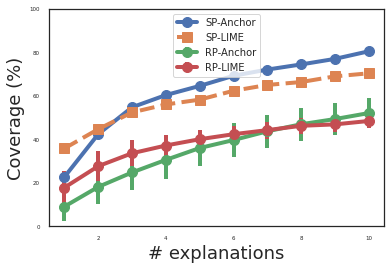

In [64]:
# papers' results for adult
path = os.path.join( 'results', '%s-%s.pickle' % ('adult', 'xgboost'))

with open(path, 'rb') as f:
  u = pickle._Unpickler(f)
  u.encoding = 'latin1'
  pickles = u.load()
  print(pickles)

fig = make_graph(pickles , save='results/papaer_adult_graphs.png')

{'lime_pred_random': ([0.9961764389624145, 0.9965035865272671, 0.9945679827874958, 0.995681073345155, 0.9950638626726181, 0.9928443094141643, 0.9932421810535396, 0.9933629408748191, 0.9931977896872115, 0.9929699463646566], [0.018561702127659577, 0.03418156028368794, 0.043991489361702135, 0.05454468085106383, 0.061744680851063834, 0.06558581560283687, 0.07231773049645389, 0.07850780141843972, 0.08058156028368794, 0.08657588652482269], [0.018371485208747363, 0.014317956170805625, 0.016290939614255963, 0.013860551497575986, 0.012899362677591446, 0.013292841950337341, 0.012868319850189979, 0.012196690453699794, 0.01174533009922084, 0.010822161675979273], [0.022118319723727572, 0.02728527966862795, 0.028680479404961937, 0.03014549444728105, 0.029539840605338128, 0.028149555538020118, 0.028087103016641128, 0.02835896624084141, 0.027218002812084096, 0.025774993544884175]), 'lime_pred_submodular_threshold': 0.77, 'lime_pred_submodular': ([434, 372, 99, 100, 38, 11, 698, 15, 39, 57], [1.0, 0.98

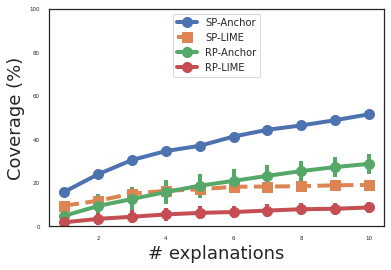

In [65]:

# papers' results
path = os.path.join( 'results', 'p-%s-%s.pickle' % ('recidivism', 'xgboost'))

with open(path, 'rb') as f:
  u = pickle._Unpickler(f)
  u.encoding = 'latin1'
  pickles = u.load()
  print(pickles)

graph  = make_graph(pickles , save='results/papaer_rcdv_graphs.png')


## Our results
run compute explanations with:
1. adult + anchor + xgboost
   adult + lime + xgboost
2. rcdv + anchor + xgboost
   rcdv + lime + xgboost

## Adult data

Train 0.8812213740458015
Test 0.8219512195121951
anchor
100
200
300
400
Train 0.8812213740458015
Test 0.8219512195121951
lime
100
200
300
400
accuracy 0.8219512195121951
Lime weights
Submodular anchor
0 0.13447432762836187
1 0.26405867970660146
2 0.33007334963325186
3 0.38875305623471884
4 0.4278728606356968
5 0.4572127139364303
6 0.4841075794621027
7 0.5036674816625917
8 0.5232273838630807
9 0.5403422982885085
Submodular lime pred
0.5 0.8414634146341463 1.0
0.51 0.8390243902439024 1.0
0.52 0.8414634146341463 1.0
0.53 0.8439024390243902 1.0
0.54 0.8512195121951219 1.0
0.55 0.8365853658536585 1.0
0.56 0.8512195121951219 1.0
0.5700000000000001 0.8609756097560975 1.0
0.58 0.8585365853658536 1.0
0.59 0.8560975609756097 1.0
0.6 0.8512195121951219 1.0
0.61 0.8536585365853658 1.0
0.62 0.848780487804878 1.0
0.63 0.8707317073170732 1.0
0.64 0.8658536585365854 1.0
0.65 0.8658536585365854 1.0
0.66 0.848780487804878 1.0
0.67 0.8536585365853658 1.0
0.6799999999999999 0.8536585365853658 1.0
0.69 0.8

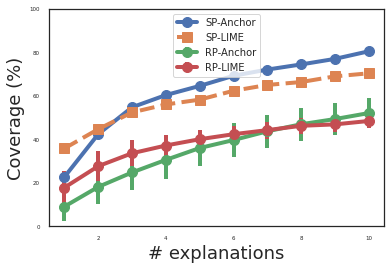

In [67]:
dataset_folder = 'datasets/'
dataset = utils.load_dataset('adult', balance=True, dataset_folder=dataset_folder, discretize=True)
dataset_name = 'adult'

ret = run_compute_explanations(dataset, 'xgboost', 'anchor')
ret_lime = run_compute_explanations(dataset, 'xgboost', 'lime')
run_process_results(dataset_name)


path_to_out_p = os.path.join( 'results', '%s-%s.pickle' % (dataset_name, 'xgboost'))
with open(path_to_out_p, 'rb') as f:
  o = pickle._Unpickler(f)
  o.encoding = 'latin1'
  pickles_ = o.load()

graph  = make_graph(pickles_ , save='results/graphs.png')

## rcdv dataset

In [68]:
dataset = utils.load_dataset('recidivism', balance=True, dataset_folder='datasets', discretize=True)

Train 0.7029281277728483
Test 0.675177304964539
anchor
100
200
300
400
500
600
700
Train 0.7029281277728483
Test 0.675177304964539
lime
100
200
300
400
500
600
700
accuracy 0.675177304964539
Lime weights
Submodular anchor
0 0.18892045454545456
1 0.27698863636363635
2 0.31676136363636365
3 0.3494318181818182
4 0.37357954545454547
5 0.3963068181818182
6 0.4147727272727273
7 0.43323863636363635
8 0.4502840909090909
9 0.46732954545454547
Submodular lime pred
0.5 0.7276595744680852 1.0
0.51 0.7177304964539007 1.0
0.52 0.7276595744680852 1.0
0.53 0.7404255319148936 1.0
0.54 0.7361702127659574 1.0
0.55 0.7390070921985815 1.0
0.56 0.7333333333333333 1.0
0.5700000000000001 0.7475177304964539 1.0
0.58 0.75177304964539 1.0
0.59 0.7390070921985815 1.0
0.6 0.7309352517985611 0.9858156028368794
0.61 0.735080058224163 0.9744680851063829
0.62 0.7276720351390923 0.9687943262411347
0.63 0.7622047244094489 0.900709219858156
0.64 0.7986230636833046 0.8241134751773049
0.65 0.8079847908745247 0.746099290780

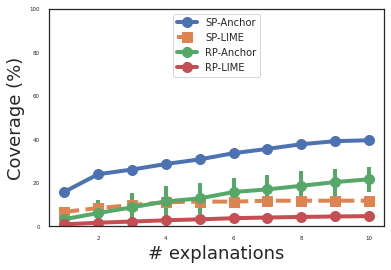

In [69]:
dataset_name = 'rcdv'
ret = run_compute_explanations(dataset, 'xgboost', 'anchor')
ret_lime = run_compute_explanations(dataset, 'xgboost', 'lime')
run_process_results(dataset_name)

path_to_out_p = os.path.join( 'results', 'our-%s-%s.pickle' % (dataset_name, 'xgboost'))
# our results
with open(path_to_out_p, 'rb') as f:
  o = pickle._Unpickler(f)
  o.encoding = 'latin1'
  pickles_ = o.load()

graph  = make_graph(pickles_ , save='results/rcdv-graphs.png')